In [1]:
import os
os.chdir("..")

Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor, AdaptParams, AdaptiveMixtureSampler

In [3]:
import numpy as np

def get_error_stats(sim, obs, pcol="exc_prb", ycol="precip_avg_mm", to_inches=True):
    f = 25.4 if to_inches else 1.0
    cx = (1 / sim[pcol].to_numpy()).astype(float)
    cy = (sim[ycol].to_numpy() / f).astype(float)
    mx = (1 / obs[pcol].to_numpy()).astype(float)
    my = (obs[ycol].to_numpy() / f).astype(float)

    # clean & sort
    okc, okm = np.isfinite(cx*cy), np.isfinite(mx*my)
    cx, cy = cx[okc], cy[okc]; mx, my = mx[okm], my[okm]
    i, j = np.argsort(cx), np.argsort(mx)
    cx, cy, mx, my = cx[i], cy[i], mx[j], my[j]

    # integer grid 1..floor(max mx)
    xmax = float(mx.max())
    grid = np.arange(1, int(np.floor(xmax)) + 1, dtype=float)

    cyg = np.interp(grid, cx, cy)
    myg = np.interp(grid, mx, my)
    rmse = float(np.sqrt(np.mean((cyg - myg) ** 2)))

    # diff at exact max of monte
    diff_at_max = float(np.interp(xmax, cx, cy) - np.interp(xmax, mx, my))
    return {"rmse": rmse, "diff_at_max": diff_at_max}

Preprocess data

In [ ]:
kanawha = Preprocessor(config_path = "/workspaces/Importance-Sampling-for-SST/data/0_source/Kanawha/config.json", 
                       output_folder = "/workspaces/Importance-Sampling-for-SST/data/1_interim/Kanawha")
kanawha.run()

In [3]:
kanawha = Preprocessor.load(config_path = "/workspaces/Importance-Sampling-for-SST/data/1_interim/Kanawha/config.json")

Full Monte Uniform Samples

In [4]:
sampler = ImportanceSampler(
    distribution="uniform",
    params = {},
    num_simulations=1_000_000,
    num_rep=1,
)

kanawha_fullmonte_samples = sampler.sample(kanawha.domain_gdf, kanawha.watershed_gdf)

In [5]:
processor = StormDepthProcessor(
    precip_cube=kanawha.cumulative_precip,
    storm_centers=kanawha.storm_centers,
    watershed_gdf=kanawha.watershed_gdf
)

kanawha_fullmonte_depths = processor.shift_and_extract_precip(
    df_storms=kanawha_fullmonte_samples,
    n_jobs=-1,    
    seed=42   
)

In [6]:
#Save
kanawha_fullmonte_depths.to_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Kanawha/kanawha_fullmonte_depths.pq")

In [ ]:
#Read
kanawha_fullmonte_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Kanawha/kanawha_fullmonte_depths.pq")

Importance Sampling - Truncated Normals

In [6]:
#Sample
params = {
    "mu_x": trinity.watershed_stats["x"],  
    "mu_y": trinity.watershed_stats["y"],      
    "sd_x": trinity.watershed_stats["range_x"],
    "sd_y": trinity.watershed_stats["range_y"]*0.5,                            
}

sampler = ImportanceSampler(
    distribution="truncated_gaussian",
    params=params,
    num_simulations=350_000,
    num_rep=1,
    seed=42,
)

samples = sampler.sample(trinity.domain_gdf)

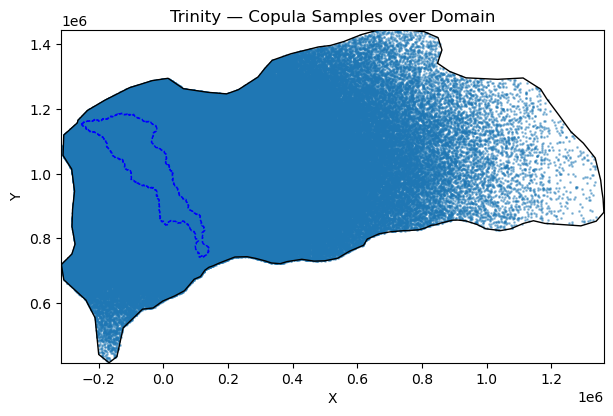

In [9]:
import matplotlib.pyplot as plt

# Plot domain and watershed boundaries
fig, ax = plt.subplots(figsize=(7,7))
trinity.domain_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
trinity.watershed_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=1, linestyle="--")

# Scatter all samples (x, y)
ax.scatter(
    samples["x"].to_numpy(),
    samples["y"].to_numpy(),
    s=1, alpha=0.4
)

# Nice axes and title
ax.set_aspect("equal", adjustable="box")
minx, miny, maxx, maxy = trinity.domain_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Trinity — Copula Samples over Domain")
plt.show()

In [10]:
#Transpose
processor = StormDepthProcessor(
    precip_cube=trinity.cumulative_precip,
    storm_centers=trinity.storm_centers,
    watershed_gdf=trinity.watershed_gdf
)

trinity_gaussian_depths = processor.shift_and_extract_precip(
    df_storms=samples,
    n_jobs=-1,    
    seed=42   
)

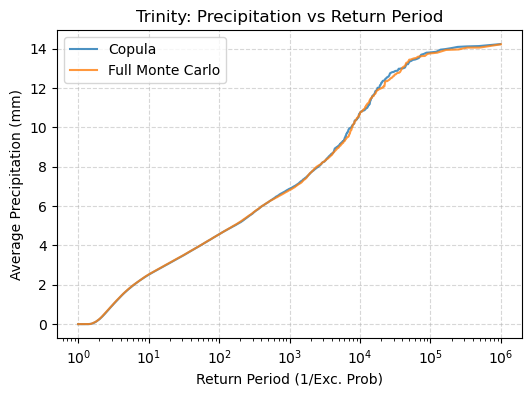

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(1/trinity_gaussian_depths["exc_prb"], trinity_gaussian_depths["precip_avg_mm"]/25.4, 
         label="Copula", alpha=0.8)
plt.plot(1/trinity_fullmonte_depths["exc_prb"], trinity_fullmonte_depths["precip_avg_mm"]/25.4, 
         label="Full Monte Carlo", alpha=0.8)

plt.xscale("log")  # log scale for return period
plt.xlabel("Return Period (1/Exc. Prob)")
plt.ylabel("Average Precipitation (mm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Trinity: Precipitation vs Return Period")
plt.show()

In [12]:
get_error_stats(trinity_gaussian_depths,trinity_fullmonte_depths,pcol="exc_prb", ycol="precip_avg_mm", to_inches=True)

{'rmse': 0.07358964184733646, 'diff_at_max': 0.009600114041223407}

Importance Sampling - Gaussian Copula

In [27]:
#Sample
params = {
    "mu_x": trinity.watershed_stats["x"],  
    "mu_y": trinity.watershed_stats["y"],      
    "sd_x": trinity.watershed_stats["range_x"],
    "sd_y": trinity.watershed_stats["range_y"]*0.5, 
    "rho": -0.2,                                
}

sampler = ImportanceSampler(
    distribution="gaussian_copula",
    params=params,
    num_simulations=300_000,
    num_rep=1,
    seed=42,
)

samples = sampler.sample(trinity.domain_gdf)

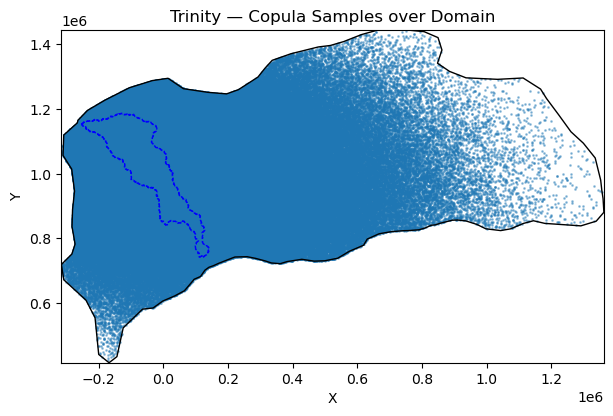

In [28]:
import matplotlib.pyplot as plt

# Plot domain and watershed boundaries
fig, ax = plt.subplots(figsize=(7,7))
trinity.domain_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
trinity.watershed_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=1, linestyle="--")

# Scatter all samples (x, y)
ax.scatter(
    samples["x"].to_numpy(),
    samples["y"].to_numpy(),
    s=1, alpha=0.4
)

# Nice axes and title
ax.set_aspect("equal", adjustable="box")
minx, miny, maxx, maxy = trinity.domain_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Trinity — Copula Samples over Domain")
plt.show()


In [29]:
#Transpose
processor = StormDepthProcessor(
    precip_cube=trinity.cumulative_precip,
    storm_centers=trinity.storm_centers,
    watershed_gdf=trinity.watershed_gdf
)

trinity_copula_depths = processor.shift_and_extract_precip(
    df_storms=samples,
    n_jobs=-1,    
    seed=42   
)

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(1/trinity_copula_depths["exc_prb"], trinity_copula_depths["precip_avg_mm"]/25.4, 
         label="Copula", alpha=0.8)
plt.plot(1/trinity_fullmonte_depths["exc_prb"], trinity_fullmonte_depths["precip_avg_mm"]/25.4, 
         label="Full Monte Carlo", alpha=0.8)

plt.xscale("log")  # log scale for return period
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (mm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Trinity: Precipitation vs Return Period")
plt.show()

NameError: name 'trinity_copula_depths' is not defined

<Figure size 600x400 with 0 Axes>

In [31]:
get_error_stats(trinity_copula_depths,trinity_fullmonte_depths,pcol="exc_prb", ycol="precip_avg_mm", to_inches=True)

{'rmse': 0.12812811981476055, 'diff_at_max': 0.02024639980838927}

Mixture of two normals

In [67]:
#Sample
params = {
    "mu_x_narrow": trinity.watershed_stats["x"],  
    "mu_y_narrow": trinity.watershed_stats["y"],
    "mu_x_wide": trinity.domain_stats["x"],  
    "mu_y_wide": trinity.domain_stats["y"],
    "sd_x_narrow": trinity.watershed_stats["range_x"]*0.3,
    "sd_y_narrow": trinity.watershed_stats["range_y"]*0.3,
    "sd_x_wide": trinity.domain_stats["range_x"],
    "sd_y_wide": trinity.domain_stats["range_y"],
    "mix": 0.8,
    "rho_narrow": -0.7,
    "rho_wide":   0.1,
}

sampler = ImportanceSampler(
    distribution="mixture_trunc_gauss",
    params=params,
    num_simulations=100_000,
    num_rep=1,
    seed=42,
)

samples = sampler.sample(trinity.domain_gdf)

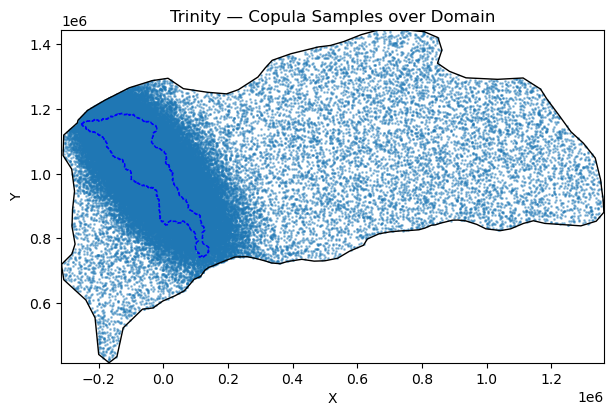

In [68]:
import matplotlib.pyplot as plt

# Plot domain and watershed boundaries
fig, ax = plt.subplots(figsize=(7,7))
trinity.domain_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
trinity.watershed_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=1, linestyle="--")

# Scatter all samples (x, y)
ax.scatter(
    samples["x"].to_numpy(),
    samples["y"].to_numpy(),
    s=1, alpha=0.4
)

# Nice axes and title
ax.set_aspect("equal", adjustable="box")
minx, miny, maxx, maxy = trinity.domain_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Trinity — Copula Samples over Domain")
plt.show()

In [69]:
#Transpose
processor = StormDepthProcessor(
    precip_cube=trinity.cumulative_precip,
    storm_centers=trinity.storm_centers,
    watershed_gdf=trinity.watershed_gdf
)

trinity_mixture_depths = processor.shift_and_extract_precip(
    df_storms=samples,
    n_jobs=-1,    
    seed=42   
)

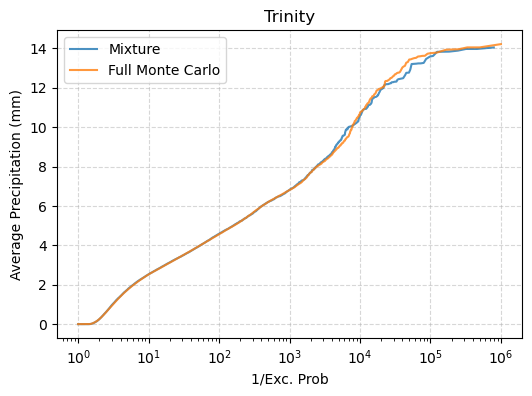

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(1/trinity_mixture_depths["exc_prb"], trinity_mixture_depths["precip_avg_mm"]/25.4, 
         label="Mixture", alpha=0.8)
plt.plot(1/trinity_fullmonte_depths["exc_prb"], trinity_fullmonte_depths["precip_avg_mm"]/25.4, 
         label="Full Monte Carlo", alpha=0.8)

plt.xscale("log")  # log scale for return period
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (mm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Trinity")
plt.show()

In [71]:
get_error_stats(trinity_mixture_depths,trinity_fullmonte_depths,pcol="exc_prb", ycol="precip_avg_mm", to_inches=True)

{'rmse': 0.1374263083646515, 'diff_at_max': -0.16899500831493874}

Adaptive Mixture

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

def plot_adaptive_evolution(history, watershed_gdf, domain_gdf, *, save=False, prefix="ais"):
    """
    history: DataFrame from sampler.adapt(...)
    watershed_gdf/domain_gdf: single-polygon GeoDataFrames in same CRS as sampler
    """
    H = history.copy().sort_values("iter")
    it = H["iter"].to_numpy()

    # ---------- Figure 1: MAP of narrow mean trajectory ----------
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
    domain_gdf.boundary.plot(ax=ax, linewidth=1.0, color="black")
    watershed_gdf.boundary.plot(ax=ax, linewidth=1.5, color="blue")

    # Plot trajectory of narrow mean
    ax.plot(H["mu_x_n"], H["mu_y_n"], "-o", markersize=3, linewidth=1.0, label="Narrow μ")

    # Annotate iteration numbers
    for i, (x, y) in enumerate(zip(H["mu_x_n"], H["mu_y_n"]), start=1):
        ax.text(x, y, str(i), fontsize=7, ha="center", va="center",
                bbox=dict(boxstyle="circle,pad=0.1", fc="white", ec="gray", lw=0.3, alpha=0.7))

    ax.set_aspect("equal", adjustable="box")
    ax.set_title("Adaptive narrow mean trajectory", pad=6)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(frameon=False, fontsize=8, loc="best")
    fig.tight_layout()
    if save:
        fig.savefig(f"{prefix}_map_narrow.png", bbox_inches="tight")

    # ---------- Figure 2: Parameters vs iteration ----------
    fig2, axs = plt.subplots(2, 2, figsize=(6, 5.5), dpi=300)
    axs = axs.ravel()

    axs[0].plot(it, H["sd_x_n"]**2, "-o", ms=3)
    axs[0].set_title("Var$_x$ (narrow)"); axs[0].set_xlabel("Iter"); axs[0].set_ylabel("sd$_x^2$")

    axs[1].plot(it, H["sd_y_n"]**2, "-o", ms=3)
    axs[1].set_title("Var$_y$ (narrow)"); axs[1].set_xlabel("Iter"); axs[1].set_ylabel("sd$_y^2$")

    axs[2].plot(it, H["mix"], "-o", ms=3)
    axs[2].set_title("Mixture weight"); axs[2].set_xlabel("Iter"); axs[2].set_ylabel("mix")

    if "hit_rate_weighted" in H:
        axs[3].plot(it, H["hit_rate_weighted"], "-o", ms=3)
        axs[3].set_title("Weighted hit rate"); axs[3].set_xlabel("Iter"); axs[3].set_ylabel("p(hit)")
    else:
        axs[3].axis("off")

    for ax in axs:
        ax.grid(alpha=0.3, linewidth=0.6)

    fig2.suptitle("Adaptive parameter evolution", y=0.995)
    fig2.tight_layout()
    if save:
        fig2.savefig(f"{prefix}_param_evolution.png", bbox_inches="tight")


In [7]:
params = AdaptParams(
    # Narrow component starts around watershed centroid
    mu_x_n=trinity.watershed_stats["x"],
    mu_y_n=trinity.watershed_stats["y"],
    sd_x_n=trinity.watershed_stats["range_x"]*0.5,
    sd_y_n=trinity.watershed_stats["range_y"]*0.5,

    # Wide component starts around full domain centroid
    mu_x_w=trinity.watershed_stats["x"],
    mu_y_w=trinity.watershed_stats["y"],
    sd_x_w=trinity.domain_stats["range_x"],
    sd_y_w=trinity.domain_stats["range_y"],

    # Optional extras
    mix=0.5,            # initial mixture weight for narrow
    rho_n=-0.7,         # correlation in narrow copula
    rho_w=0.5,          # correlation in wide copula
)

sampler = AdaptiveMixtureSampler(
    precip_cube=trinity.cumulative_precip,
    storm_centers=trinity.storm_centers,
    watershed_gdf=trinity.watershed_gdf,
    domain_gdf=trinity.domain_gdf,
    params=params,
    seed=42,
)

In [8]:
history = sampler.adapt(num_iterations=10, samples_per_iter=500)
print(history)

    iter       mix         mu_x_n        mu_y_n         sd_x_n         sd_y_n  \
0      0  0.500000  -47423.153148  1.019273e+06  196733.075237  222234.154816   
1      1  0.559148   70003.650294  9.971357e+05  265897.497335  184660.436507   
2      2  0.607803   87858.575381  9.686991e+05  272715.007215  177035.874783   
3      3  0.640394   70708.333185  9.748657e+05  257922.606155  173408.246587   
4      4  0.660395   71971.845123  9.680956e+05  262998.461225  175006.061765   
5      5  0.680523   91815.251084  9.918823e+05  258409.797224  162004.741475   
6      6  0.678865   93320.292355  9.779975e+05  265018.388241  171054.964098   
7      7  0.710843   98860.688473  9.809278e+05  283955.217853  176851.598572   
8      8  0.707769   84029.516113  9.733614e+05  284182.076564  178850.773409   
9      9  0.698858  128518.248260  9.818573e+05  285063.695767  163403.550250   
10    10  0.698750   92540.975263  9.743002e+05  282722.540181  187490.291955   

          mu_x_w        mu_

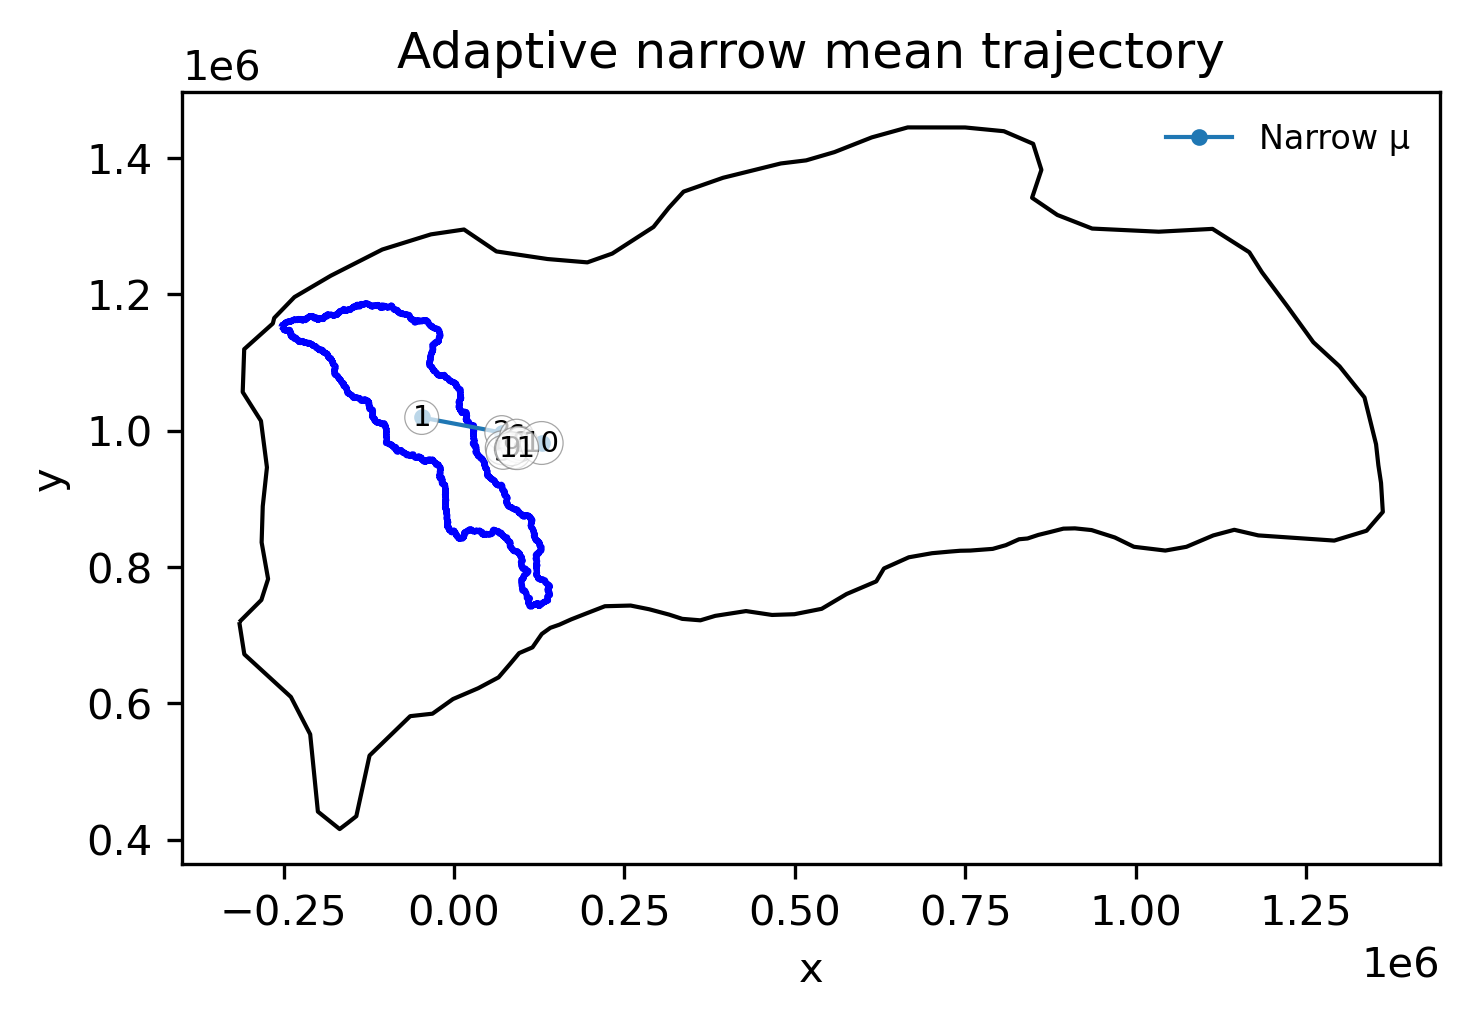

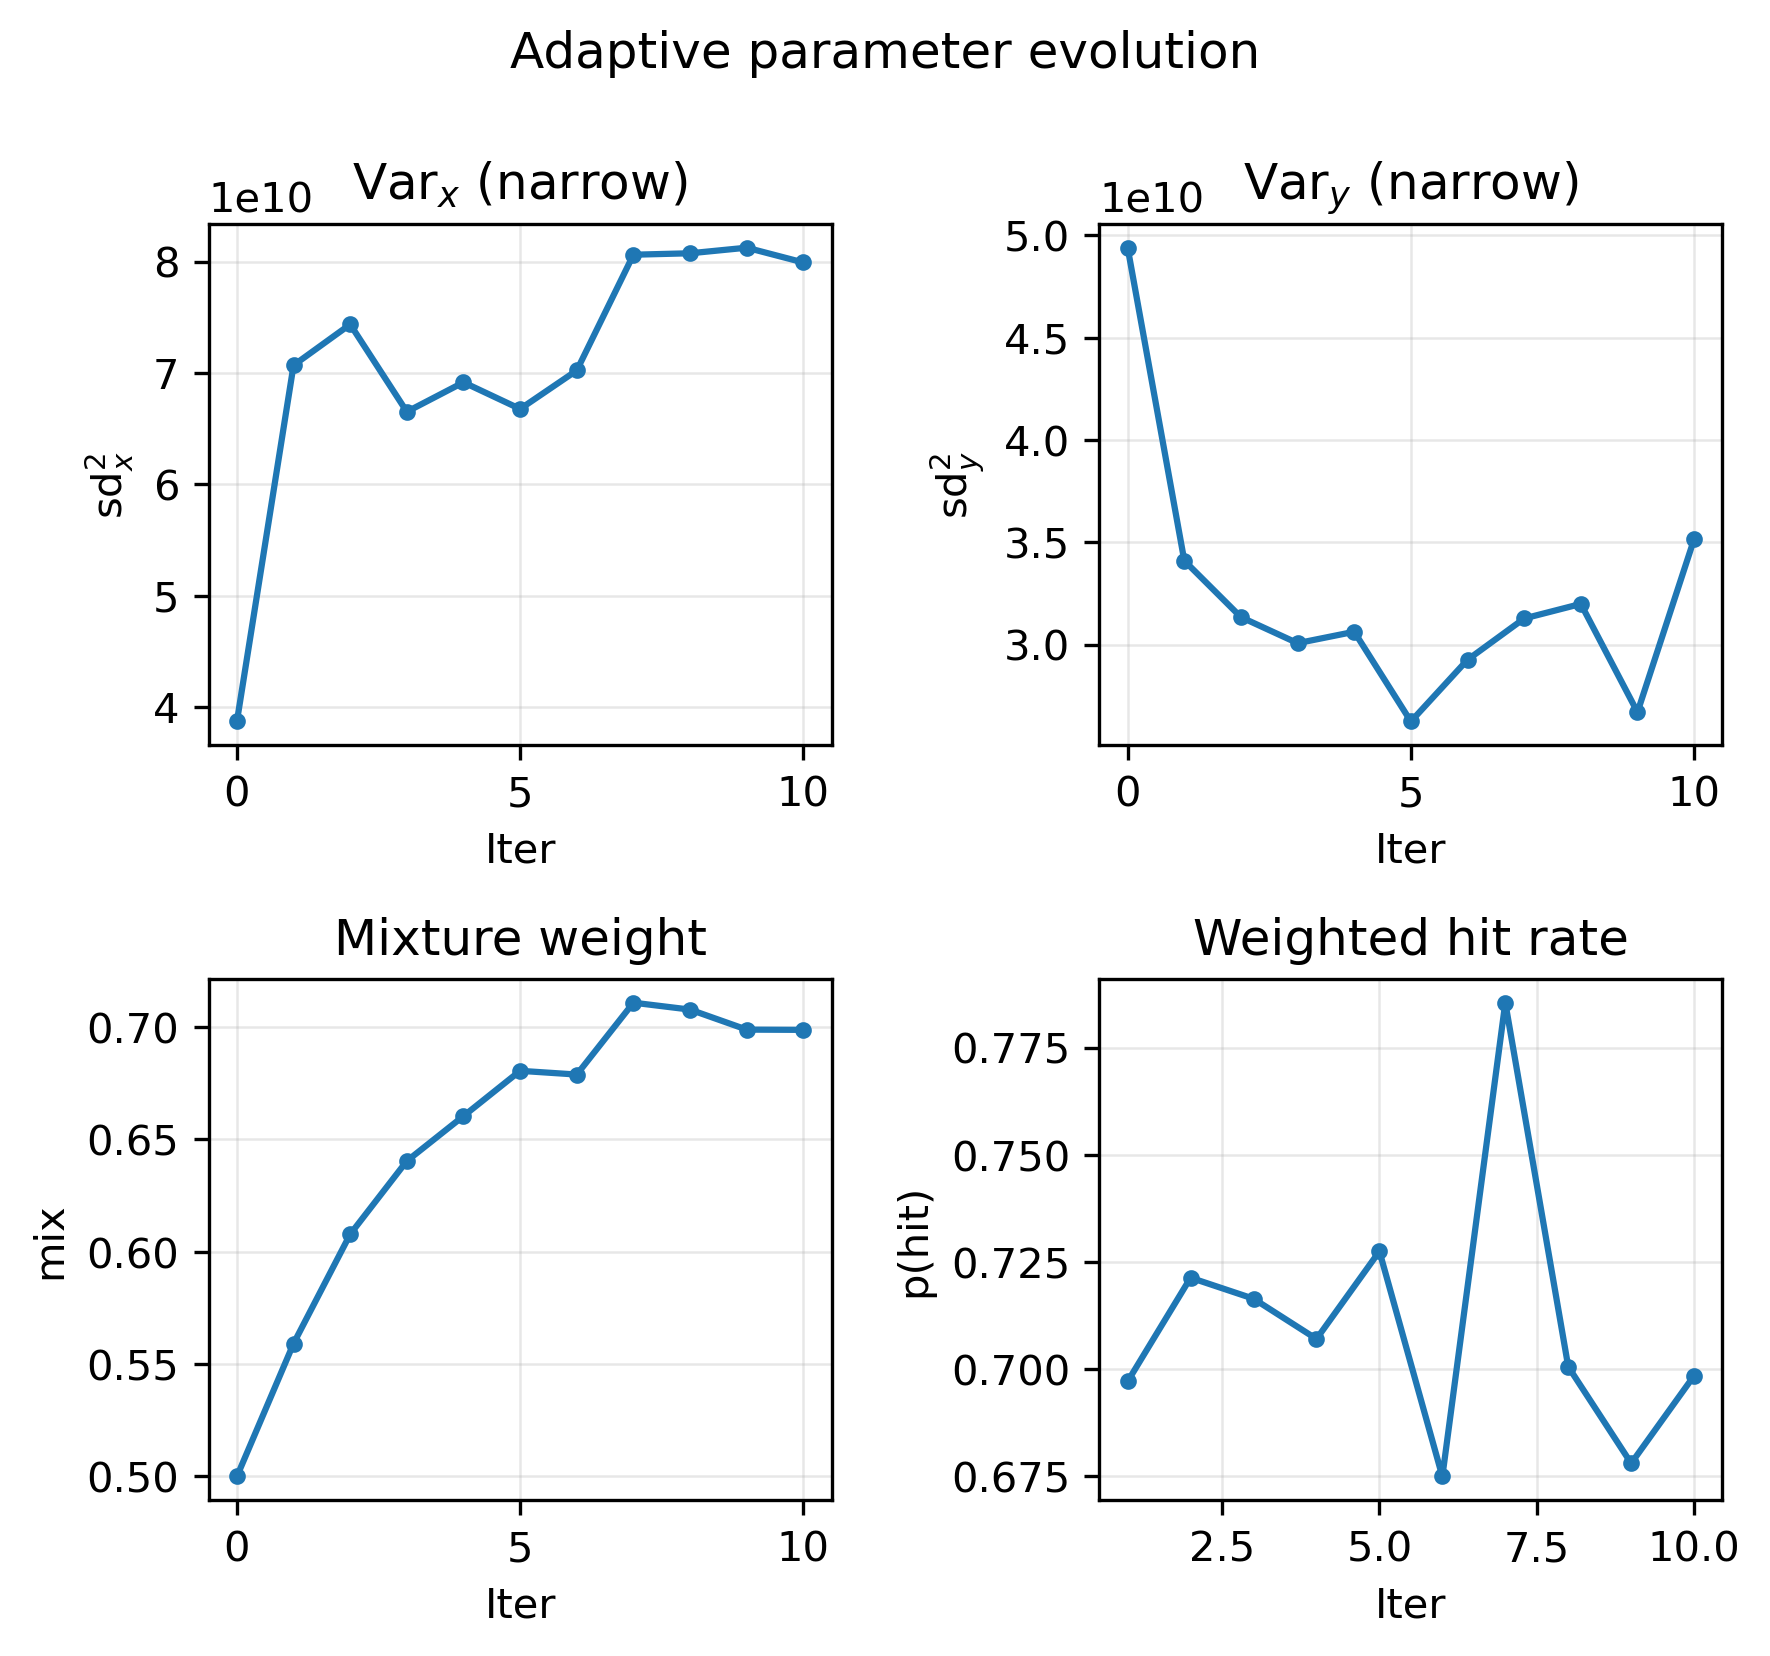

In [9]:
plot_adaptive_evolution(history, trinity.watershed_gdf, trinity.domain_gdf, save=False, prefix="trinity_ais")

In [ ]:
samples = sampler.sample_final(n=100_000, with_depths=True)
print(samples.head()) 

   rep  event_id             x             y    weight  \
0    1     13743  20501.117607  1.073742e+06  0.000004   
1    1     86248  -8235.604187  1.111223e+06  0.000005   
2    1     95130  17465.809406  1.043403e+06  0.000004   
3    1      7391  45458.629748  1.065513e+06  0.000004   
4    1     98633  58054.549959  1.062658e+06  0.000004   

               storm_path  precip_avg_mm   exc_prb  
0  20170826_72hr_st2_r004     352.589081  0.000004  
1  20170826_72hr_st2_r004     341.278809  0.000010  
2  20170826_72hr_st2_r004     340.638184  0.000014  
3  20170826_72hr_st2_r004     335.401733  0.000018  
4  20170826_72hr_st2_r004     320.584595  0.000022  


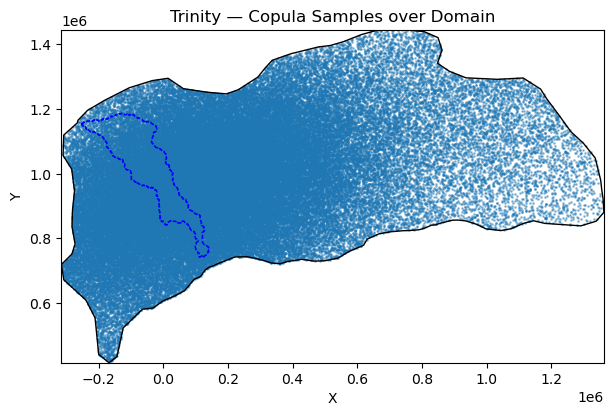

In [11]:
import matplotlib.pyplot as plt

# Plot domain and watershed boundaries
fig, ax = plt.subplots(figsize=(7,7))
trinity.domain_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
trinity.watershed_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=1, linestyle="--")

# Scatter all samples (x, y)
ax.scatter(
    samples["x"].to_numpy(),
    samples["y"].to_numpy(),
    s=1, alpha=0.4
)

# Nice axes and title
ax.set_aspect("equal", adjustable="box")
minx, miny, maxx, maxy = trinity.domain_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Trinity — Copula Samples over Domain")
plt.show()

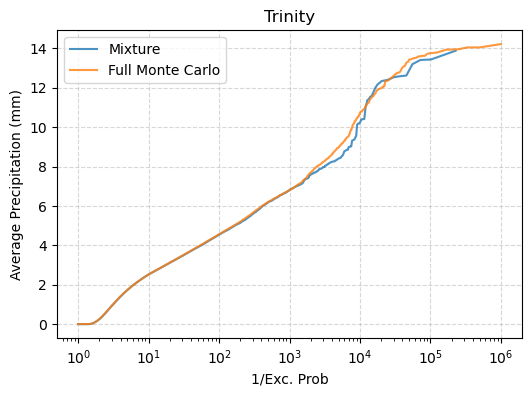

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(1/samples["exc_prb"], samples["precip_avg_mm"]/25.4, 
         label="Mixture", alpha=0.8)
plt.plot(1/trinity_fullmonte_depths["exc_prb"], trinity_fullmonte_depths["precip_avg_mm"]/25.4, 
         label="Full Monte Carlo", alpha=0.8)

plt.xscale("log")  # log scale for return period
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (mm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Trinity")
plt.show()